In [1]:
import pandas as pd
import numpy as np

# US or AG
COUNTRY = 'brazil'
# corn, soybean, wheat, sunflower
CROP_TYPE = 'corn'  # Default is corn, can be changed to 'soybean' or 'wheat'

VALID_CROP_TYPES = {
    'usa': ['corn', 'soybean', 'winter_wheat'],
    'argentina': ['wheat', 'soybean', 'corn', 'sunflower'],
    "brazil": ["corn", "soybean", "sugarcane", "cotton", "wheat"]
}

if CROP_TYPE not in VALID_CROP_TYPES[COUNTRY]:
    raise ValueError(f"Invalid crop type: {CROP_TYPE}. Valid crop types are: {VALID_CROP_TYPES[COUNTRY]}")


US_DATASET_FILE = '../data/khaki_soybeans/khaki_multi_crop_yield.csv'
OTHER_DATASET_FILES = {
    "argentina": '../data/khaki_soybeans/khaki_argentina_multi_crop.csv',
    "brazil": '../data/khaki_soybeans/khaki_brazil_multi_crop.csv',
}

DATASET_FILE = US_DATASET_FILE if COUNTRY == 'US' else OTHER_DATASET_FILES[COUNTRY]


In [ ]:
# Load the dataset
df = pd.read_csv(DATASET_FILE)
if COUNTRY == "brazil":
    df = df[
            df["State"].isin(["Goiás", "Mato Grosso", "Mato Grosso do Sul", "Paraná"])
        ].copy()


# Get average yield by year
crop_yield_col = f"{CROP_TYPE}_yield"
yearly_yields = df.groupby('year')[crop_yield_col].mean().reset_index()
yearly_yields = yearly_yields.sort_values('year')
yearly_yields.head()

In [ ]:
# Compute rolling mean and std for 5 years BEFORE current year
yearly_yields['rolling_mean'] = yearly_yields[crop_yield_col].shift(1).rolling(window=5, min_periods=5).mean()
yearly_yields['rolling_std'] = yearly_yields[crop_yield_col].shift(1).rolling(window=5, min_periods=5).std()
yearly_yields['z_score'] = (yearly_yields[crop_yield_col] - yearly_yields['rolling_mean']) / yearly_yields['rolling_std']
yearly_yields['abs_z_score'] = yearly_yields['z_score'].abs()

# Filter for 2000-2018 and sort by abs_z_score
result = yearly_yields[(yearly_yields['year'] > 2000) & (yearly_yields['year'] <= 2018)].dropna()
result = result.sort_values('abs_z_score', ascending=False)

result.head(5).sort_values('year', ascending=True)


,year,corn_yield,rolling_mean,rolling_std,z_score,abs_z_score
22,2001,2308.386335,2017.178468,94.016532,3.097411,3.097411
24,2003,2599.309692,2173.162364,138.070608,3.086445,3.086445
28,2007,2735.885138,2438.490566,116.235567,2.558551,2.558551
34,2013,3466.783177,2987.551217,203.907887,2.350237,2.350237
38,2017,3844.325954,3423.942873,162.087434,2.593558,2.593558


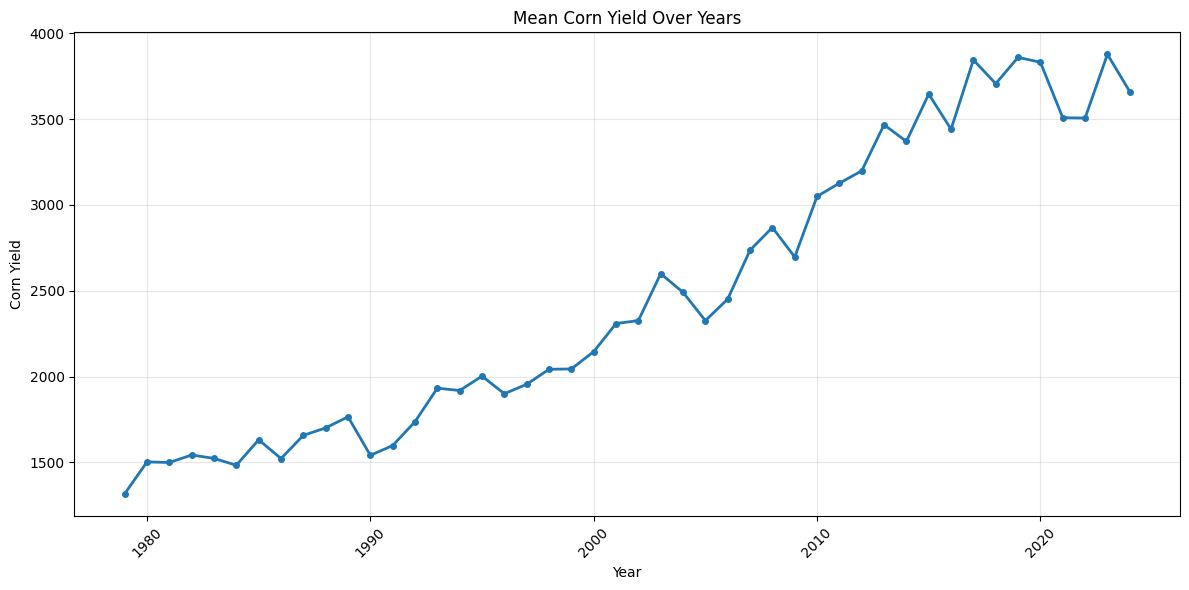

In [ ]:
# Plot mean yield over the years
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(yearly_yields['year'], yearly_yields[crop_yield_col], marker='o', linewidth=2, markersize=4)
plt.title(f'Mean {CROP_TYPE.title()} Yield Over Years')
plt.xlabel('Year')
plt.ylabel(f'{CROP_TYPE.title()} Yield')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
